<a href="https://colab.research.google.com/github/yusril713/CNN-Resnet-50/blob/main/Tesis_Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Required Libraries**

In [6]:
import os
import cv2
from keras.applications.resnet50 import preprocess_input
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Flatten, ZeroPadding2D, AveragePooling2D, MaxPooling2D, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import sys
import cv2
import os
import random

## **Load Images**

In [7]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder, filename))
            # img = cv2.equalizeHist(img)
            img = cv2.resize(img, (57,57))
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float)/255
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.equalizeHist(img)
            if img is not None:
                images.append(img.astype('float')/255)
    return images

In [8]:
root_folder = '/content/drive/MyDrive/new_dataset'
folders = [os.path.join(root_folder, x) for x in ('bahagia', 'jijik', 
                                                  'marah', 'netral', 'sedih', 
                                                  'takut', 'terkejut')]
# folders = [os.path.join(root_folder, x) for x in ('sedih', 'bahagia', 'jijik', 'marah', 'netral')]
# all_images = [img for folder in folders for img in load_images_from_folder(folder)]
images = []
label = []
for i in range(len(folders)):
  # if i == 3:
  #   break
  print("Data: ", folders[i])
  counter = 1
  for j in load_images_from_folder(folders[i]):
    images.append(j)
    label.append(to_categorical(i, num_classes=7))
    if counter == 106:
      break
    counter += 1

Data:  /content/drive/MyDrive/new_dataset/bahagia
Data:  /content/drive/MyDrive/new_dataset/jijik
Data:  /content/drive/MyDrive/new_dataset/marah
Data:  /content/drive/MyDrive/new_dataset/netral
Data:  /content/drive/MyDrive/new_dataset/sedih
Data:  /content/drive/MyDrive/new_dataset/takut
Data:  /content/drive/MyDrive/new_dataset/terkejut


## **Split Training and Testing Data**

In [9]:
train_test_data = np.array(images)
train_test_label = np.array(label)
x_train, x_test, y_train, y_test = train_test_split(train_test_data, train_test_label, test_size = 0.1, shuffle = True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(667, 57, 57) (667, 7)
(75, 57, 57) (75, 7)


## **Data Augmentation**

In [10]:
label_img_augment, img_augment = [], []

for a in range(len(x_train)):
    # load the image
    # convert to numpy array
    img = x_train[a, :, :].tolist()
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(horizontal_flip=True)
    # prepare iterator
    it = datagen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(9):
        # define subplot
        # pyplot.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('float')
        img_augment.append(image)
        label_img_augment.append(y_train[a])
        # plot raw pixel data
#         pyplot.imshow(image)
    # show the figure
#     pyplot.show()

    # create image data augmentation generator
    datagen = ImageDataGenerator(rotation_range=90)
    # prepare iterator
    it = datagen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(9):
        # define subplot
        # pyplot.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('float')
        img_augment.append(image)
        label_img_augment.append(y_train[a])
        # plot raw pixel data
#         pyplot.imshow(image)
    # show the figure
#     pyplot.show()

    datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
    # prepare iterator
    it = datagen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(9):
        # define subplot
        # pyplot.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('float')
        img_augment.append(image)
        label_img_augment.append(y_train[a])

## **Split Training and Validation Data**

In [11]:
train_val_data = np.array(img_augment)
train_val_label = np.array(label_img_augment)

# def normalize_with_moments(x, axes=[0, 1], epsilon=1e-8):
#     mean, variance = tf.nn.moments(x, axes=axes)
#     x_normed = (x - mean) / tf.sqrt(variance + epsilon) # epsilon to avoid dividing by zero
#     return x_normed

# train_val_data = tf.transpose(train_val_data.astype('float'))
# train_val_data = normalize_with_moments(train_val_data)

x_train, x_val, y_train, y_val = train_test_split(train_val_data, train_val_label, test_size = 0.1, shuffle = True)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(16208, 57, 57, 1) (16208, 7)
(1801, 57, 57, 1) (1801, 7)


## **Create Datesets**

In [12]:
def generateDataset(input, label, kode):
  print("Create data ", kode)
  with open ('/content/drive/MyDrive/new_dataset/x_' + str(kode) + '.pkl', 'wb') as f:
    pickle.dump(input,f)
  
  print("Create data ", kode)
  with open ('/content/drive/MyDrive/new_dataset/y_' + str(kode) + '.pkl', 'wb') as f:
    pickle.dump(label,f)

# train_val_data = np.array(images)
# train_val_label = np.array(label)
# x_train, x_val, y_train, y_val = train_test_split(train_val_data, train_val_label, test_size = 0.1, shuffle = True)

# train_val_data = x_train
# train_val_label = y_train
# x_train, x_test, y_train, y_test = train_test_split(train_val_data, train_val_label, test_size = 0.1, shuffle = True)

generateDataset(x_train, y_train, "train") 
generateDataset(x_test, y_test, "test")
generateDataset(x_val, y_val, "val")
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

Create data  train
Create data  train
Create data  test
Create data  test
Create data  val
Create data  val
(16208, 57, 57, 1)
(16208, 7)
(1801, 57, 57, 1)
(1801, 7)
(75, 57, 57)
(75, 7)


## **Load Datasets**

In [13]:
def loadData(kode):
  with open('/content/drive/MyDrive/new_dataset/x_' + str(kode) + '.pkl', 'rb' ) as f:
    X = pickle.load(f) 

  with open('/content/drive/MyDrive/new_dataset/y_' + str(kode)+ '.pkl', 'rb' ) as f:
    y = pickle.load(f)
    return X, y 

x_train, y_train = loadData("train")
x_test, y_test = loadData("test")
x_val, y_val = loadData("val")
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(16208, 57, 57, 1)
(16208, 7)
(1801, 57, 57, 1)
(1801, 7)
(75, 57, 57)
(75, 7)


## **Construct The Identity Block**

In [14]:
# construct the identity block
def block_iden(X, size_filter, num_filter):
    
    # number of filters used in the 3 conv layer
    f1 = num_filter[0]
    f2 = num_filter[1]
    f3 = num_filter[2]
    
    # store the X as a shortcut first
    X_short = X
    
    X = Conv2D(filters = f1, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = f2, kernel_size = (size_filter,size_filter), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = f3, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3)(X)
    
    X = Add()([X, X_short])
    
    X = Activation('relu')(X)
    
    return X

## **Construct The Convolution Block**

In [15]:
# construct the convolution block
def block_conv(X, size_filter, num_filter, size_stride):
    
    # number of filters used in the 3 conv layer
    f1 = num_filter[0]
    f2 = num_filter[1]
    f3 = num_filter[2]
    
    # store the X as a shortcut first
    X_short = Conv2D(filters = f3, kernel_size = (1,1), strides = (size_stride,size_stride), padding = 'valid', kernel_initializer = glorot_uniform(seed=None))(X)
    X_short = BatchNormalization(axis = 3)(X_short)
    
    
    X = Conv2D(filters = f1, kernel_size = (1,1), strides = (size_stride,size_stride), padding = 'valid', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = f2, kernel_size = (size_filter,size_filter), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = f3, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3)(X)
    
    X = Add()([X, X_short])
    
    X = Activation('relu')(X)
    
    return X

## **Construct The Model**

In [16]:
# construct the model
def resnet50(shape, classes):
    
    X_input = Input(shape)
    # zero padding
    X = ZeroPadding2D(padding = (3,3))(X_input)
    
    # stage 1
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2), kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (3,3), strides = (2,2))(X)
    
    # stage 2
    X = block_conv(X, 3, [64,64,256], 1)
    X = block_iden(X, 3, [64,64,256])
    X = block_iden(X, 3, [64,64,256])
    
    # stage 3
    X = block_conv(X, 3, [128,128,512], 2)
    X = block_iden(X, 3, [128,128,512])
    X = block_iden(X, 3, [128,128,512])
    X = block_iden(X, 3, [128,128,512])
    
    # stage 4
    X = block_conv(X, 3, [256,256,1024], 2)
    X = block_iden(X, 3, [256,256,1024])
    X = block_iden(X, 3, [256,256,1024])
    X = block_iden(X, 3, [256,256,1024])
    X = block_iden(X, 3, [256,256,1024])
    X = block_iden(X, 3, [256,256,1024])
    
    # stage 5
    X = block_conv(X, 3, [512,512,2048], 2)
    X = block_iden(X, 3, [512,512,2048])
    X = block_iden(X, 3, [512,512,2048])
    
    # final stage
    X = AveragePooling2D(pool_size = (2,2))(X)
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', kernel_initializer = glorot_uniform(seed=None))(X)
    
    # model
    model = Model(X_input, X, name = 'ResNet50')
    
    return model

## **Initialize Model Resnet 50**

In [17]:
model = resnet50((57,57,1), 7)


## **Compile The Model**

In [18]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model architecture 
model.summary()

## **Training CNN Resnet 50**

In [22]:
max_epoch = 100
base_lr = 0.00001
batchSize = [128, 64, 32, 16, 8, 4, 2, 1]
def step_decay2(epoch): #Function yang bertujuan untuk menurunkan nilai learning rate disetiap epoch
  #--------Keterangan variabel---------#
  #epoch : nilai epoch ke-n atau saat ini
  #maxEpoch : nilai epoch maksimal
  #baseLr : nilai learning awal
  maxEpochs = max_epoch
  baseLR = base_lr
  power = 1.0 # turns our polynomial decay into a linear decay
  
    # compute the new learning rate based on polynomial decay
  alpha = baseLR * (1 - (epoch / maxEpochs)) ** power
  return alpha

# start the training process
history = []
for i in batchSize:
  print("Batch Size: ", i)
  checkpoint_name = '/content/drive/MyDrive/new_dataset/model/model_' + str(i) + '_batch_size.hdf5' #Inisialisasi lokasi dan nama bobot yang model yang akan disimpan
  checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose=1, batch_size=i, save_best_only=True, mode='min') #Function dari tensorflow untuk menyimpan bobot model berdasarkan nilai val_loss terkecil
  lrate = LearningRateScheduler(step_decay2) #Function tensorflow untuk menurunkan nilai learning rate secara berkala dengan memanfaatkan function step_decay2()
  callbacks_list = [checkpoint,lrate]


  hist = model.fit(x_train, y_train, epochs = max_epoch, batch_size = i, validation_data=(x_val,y_val), callbacks=callbacks_list) #Memulai pelatihan
  history.append(hist.history)
  print("\n\n")

Epoch 1/10
127/127 [==============================] - 19s 131ms/step - loss: 1.3005 - accuracy: 0.5169 - val_loss: 1.3540 - val_accuracy: 0.5014

Epoch 00001: val_loss improved from inf to 1.35402, saving model to /content/drive/MyDrive/new_dataset/model/model_128_batch_size.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
127/127 [==============================] - 16s 125ms/step - loss: 1.2422 - accuracy: 0.5391 - val_loss: 1.3976 - val_accuracy: 0.4781

Epoch 00002: val_loss did not improve from 1.35402
Epoch 3/10
127/127 [==============================] - 16s 125ms/step - loss: 1.1849 - accuracy: 0.5642 - val_loss: 1.4185 - val_accuracy: 0.4853

Epoch 00003: val_loss did not improve from 1.35402
Epoch 4/10
127/127 [==============================] - 16s 125ms/step - loss: 1.1431 - accuracy: 0.5810 - val_loss: 1.5133 - val_accuracy: 0.4831

Epoch 00004: val_loss did not improve from 1.35402
Epoch 5/10
127/127 [==============================] - 16s 127ms/step - loss: 1.0646 - accuracy: 0.6161 - val_loss: 1.1812 - val_accuracy: 0.5713

Epoch 00005: val_loss improved from 1.35402 to 1.18117, saving model to /content/drive/MyDrive/new_dataset/model/model_128_batch_size.hdf5
Epoch 6/10
127/127 [==============================] - 16s 127ms/step - loss: 1.0204 - accuracy: 0.6332 - val_loss: 1.1804 - 

KeyboardInterrupt: ignored

## **Testing CNN Resnet 50**

In [24]:
# evaluate the model using the validation data
tf.keras.backend.clear_session() #Mereset bobot model
# for i in len(range(x_test)):
#   x_test[i] = x_test[i].astype('float')/255
for i in batchSize:
  model = load_model('/content/drive/MyDrive/new_dataset/model/model_' + str(i) + '_batch_size.hdf5') #Load bobot model yang baru disimpan
  preds = model.evaluate(x_test, y_test)

  print ("Validation Loss = " + str(preds[0]))
  print ("Validation Accuracy = " + str(preds[1]))

3/3 [==============================] - 1s 27ms/step - loss: 1.5344 - accuracy: 0.4667
Validation Loss = 1.534413456916809
Validation Accuracy = 0.46666666865348816
3/3 [==============================] - 1s 28ms/step - loss: 1.6656 - accuracy: 0.4267
Validation Loss = 1.665631890296936
Validation Accuracy = 0.4266666769981384
3/3 [==============================] - 1s 26ms/step - loss: 1.6073 - accuracy: 0.4933
Validation Loss = 1.6073168516159058
Validation Accuracy = 0.4933333396911621


## **Plot Loss & Validation Loss**

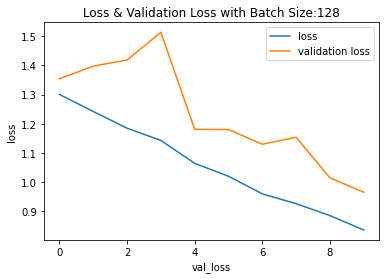

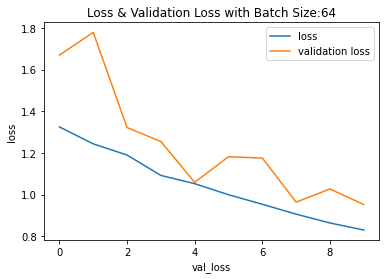

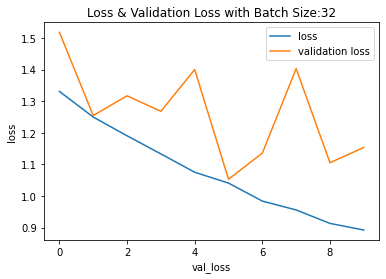

In [23]:
import matplotlib.pyplot as plt

for i in range(len(history)):
  loss = history[i]['loss']
  val_loss = history[i]['val_loss']
  epoch = np.arange(0,len(history[i]['loss']))
  plt.title('Loss & Validation Loss with Batch Size:' + str(batchSize[i]))
  plt.plot(epoch, loss)
  plt.plot(epoch, val_loss)
  plt.ylabel('loss')
  plt.xlabel('val_loss')
  plt.legend(['loss', 'validation loss'], loc='upper right')
  plt.show()